In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import json
from detectron2 import model_zoo 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg 
from detectron2.utils.visualizer import Visualizer 
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
import os.path as osp
import os
from utils.utils import move_train_test 
import random
import pickle



In [2]:

main_folder = "dataset/data_new/data"
path_divided = {"train": "dataset/data_final/train", "valid": "dataset/data_final/valid", "test": "dataset/data_final/test"}

In [3]:
# move_train_test(main_folder, path_divided,valid = 0.2, test = 0.2)

In [4]:
def get_wound_dict(directory):
    classes = ['leg', 'wound']
    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(directory)):
        if "check" in filename:
            continue
        json_file = os.path.join(*[directory, filename, str(filename) + ".json"])
        with open(json_file) as f:
            img_anns = json.load(f)
        record = {}
        leg = False
        filename = os.path.join(*[directory, filename, str(filename) + ".jpg"])
        
        record["file_name"],record["image_id"],record["height"], record["width"] = filename, filename, 512, 512
        img = cv2.imread(record["file_name"])    
        h_scale = 512/img_anns["imageHeight"]
        w_scale = 512/img_anns["imageWidth"]
        img = cv2.resize(img, (512,512))
        cv2.imwrite(record["file_name"],img)
        annos = img_anns["shapes"]
        objs = []
        for anno in annos: 
            px = [(a[0]*w_scale) for a in anno['points']]
            py = [(a[1]*h_scale) for a in anno['points']]
            poly = [(x,y) for x,y in zip(px,py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "valid", "test"]:
    DatasetCatalog.register("wound_" + d, lambda d=d: get_wound_dict(path_divided[d]))
    MetadataCatalog.get("wound_" + d).set(thing_classes=['leg','wound'])
wound_metadata = MetadataCatalog.get("wound_train")

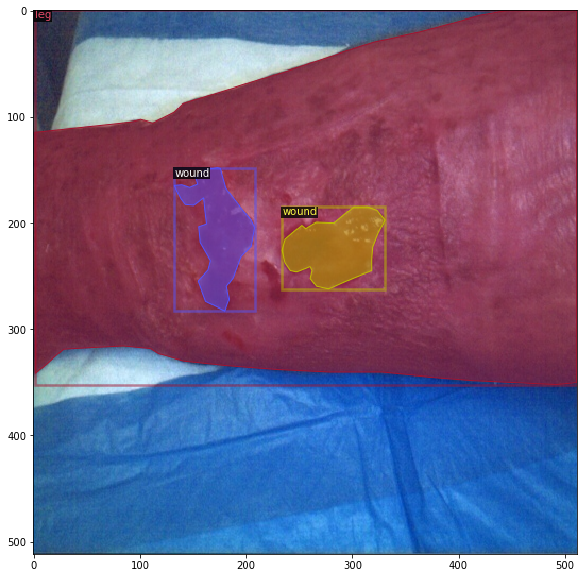

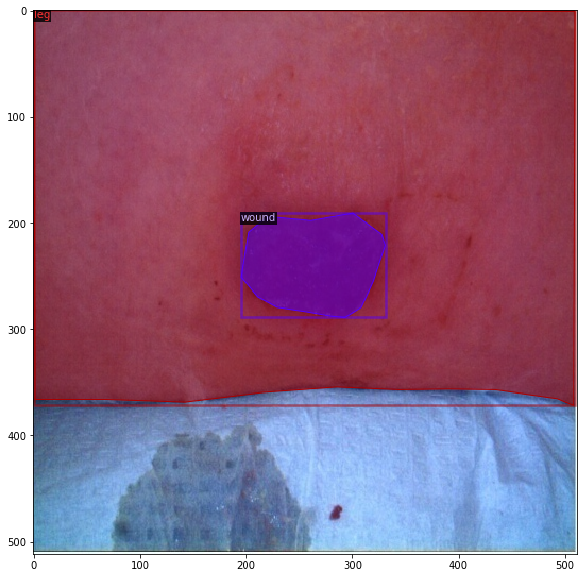

In [6]:

dataset_dicts = get_wound_dict(path_divided["train"])
for d in ["train", "valid", "test"]:
    dataset_dicts = get_wound_dict(path_divided[d])
    with open("{}.pickle".format(d), "wb") as f:
        pickle.dump(dataset_dicts, f)
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=wound_metadata, scale=1)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wound_train",)
cfg.DATASETS.TEST = ("wound_valid",) 
cfg.TEST.EVAL_PERIOD = 5
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/21 22:43:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/21 22:43:47 d2.data.build]: Removed 0 images with no usable annotations. 222 images left.
[09/21 22:43:47 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    leg     | 223          |   wound    | 256          |
|            |              |            |              |
|   total    | 479          |            |              |
[09/21 22:43:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/21 22:43:47 d2.data.build]: Using training sampler TrainingSampler
[09/21 22:43:47 d2.data.common]: Serializing 222 elements to byte tensors and concatenating them all ...
[09/21 22:43:47 d2.data.common]: Serialized dataset takes 0.29 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[09/21 22:43:48 d2.engine.train_loop]: Starting training from iteration 0
[09/21 22:43:50 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    leg     | 73           |   wound    | 78           |
|            |              |            |              |
|   total    | 151          |            |              |
[09/21 22:43:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:43:50 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:43:50 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:43:50 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:43:51 d2.data.dataset_mapper]: [DatasetMapper]

[09/21 22:44:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:44:08 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:44:08 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:44:08 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:44:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:44:09 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:44:09 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:44:09 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/

WARNING [09/21 22:44:26 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:44:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:44:27 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:44:27 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:44:27 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:44:27 d2.utils.events]:  eta: 0:02:19  iter: 139  total_loss: 0.9906  loss_cls: 0.1986  loss_box_reg: 0.1847  loss_mask: 0.5565  loss_rpn_cls: 0.02585  loss_rpn_loc: 0.01692  time: 0.1605  data_time: 0.0033  lr: 3.4965e-05  max_mem: 1857M
[09/21 22:44:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortest

[09/21 22:44:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:44:45 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:44:45 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:44:45 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:44:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:44:47 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:44:47 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:44:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/

WARNING [09/21 22:45:03 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:45:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:45:05 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:45:05 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:45:05 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:45:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:45:06 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:45:06 d2.data.common]: Serialized dataset takes 0.09 MiB
WARN

[09/21 22:45:22 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:45:22 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:45:22 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:45:22 d2.utils.events]:  eta: 0:01:47  iter: 339  total_loss: 0.6325  loss_cls: 0.1274  loss_box_reg: 0.1896  loss_mask: 0.2944  loss_rpn_cls: 0.003408  loss_rpn_loc: 0.01142  time: 0.1614  data_time: 0.0031  lr: 8.4915e-05  max_mem: 1857M
[09/21 22:45:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:45:24 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:45:24 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:45:24 d2.engine.defaults]: No evaluator found. Use `DefaultTrai

[09/21 22:45:40 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:45:40 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:45:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:45:42 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:45:42 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:45:42 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:45:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:45:43 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/

[09/21 22:46:00 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:46:00 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:46:00 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:46:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:46:01 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:46:01 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:46:01 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:46:01 d2.utils.events]:  eta: 0:01:24  iter: 479  total_loss: 0.5712  loss_cls: 0.1146  loss_box_reg: 0.1909  loss_mask: 0.2419  loss_rpn_cls: 0.004541  loss_rpn_loc: 0.0149

[09/21 22:46:18 d2.utils.events]:  eta: 0:01:14  iter: 539  total_loss: 0.4642  loss_cls: 0.07842  loss_box_reg: 0.1643  loss_mask: 0.2018  loss_rpn_cls: 0.006439  loss_rpn_loc: 0.01326  time: 0.1614  data_time: 0.0032  lr: 0.00013487  max_mem: 1892M
[09/21 22:46:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:46:19 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:46:19 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:46:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:46:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:46:20 d2.data.common]: Serializing 74 elements to byte tensors

[09/21 22:46:37 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:46:37 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:46:37 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:46:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:46:39 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:46:39 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:46:39 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:46:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/

[09/21 22:46:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:46:57 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:46:57 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:46:57 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:46:57 d2.utils.events]:  eta: 0:00:52  iter: 679  total_loss: 0.3472  loss_cls: 0.05494  loss_box_reg: 0.1234  loss_mask: 0.1507  loss_rpn_cls: 0.001772  loss_rpn_loc: 0.01357  time: 0.1619  data_time: 0.0034  lr: 0.00016983  max_mem: 1892M
[09/21 22:46:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:46:58 d2.data.common]: Serializing 74 elements to byte tensors

[09/21 22:47:15 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:47:15 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:47:15 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:47:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:47:16 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:47:16 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:47:16 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:47:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/

[09/21 22:47:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:47:34 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:47:34 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:47:34 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:47:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:47:35 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:47:35 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:47:35 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/

[09/21 22:47:52 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:47:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:47:52 d2.utils.events]:  eta: 0:00:19  iter: 879  total_loss: 0.3029  loss_cls: 0.04675  loss_box_reg: 0.09148  loss_mask: 0.1331  loss_rpn_cls: 0.001341  loss_rpn_loc: 0.009498  time: 0.1619  data_time: 0.0033  lr: 0.00021978  max_mem: 1905M
[09/21 22:47:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:47:53 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:47:53 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:47:53 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:47:55 d2.data.dataset_ma

WARNING [09/21 22:48:10 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:48:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:48:11 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:48:11 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [09/21 22:48:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[09/21 22:48:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/21 22:48:13 d2.data.common]: Serializing 74 elements to byte tensors and concatenating them all ...
[09/21 22:48:13 d2.data.common]: Serialized dataset takes 0.09 MiB
WARN

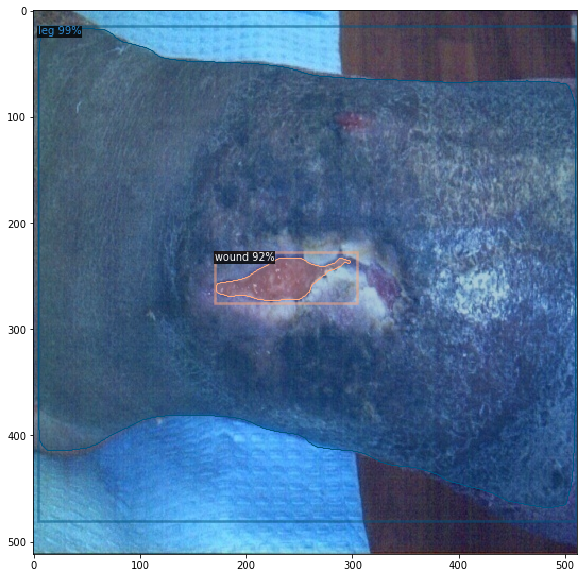

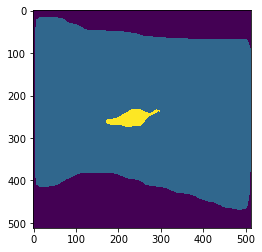

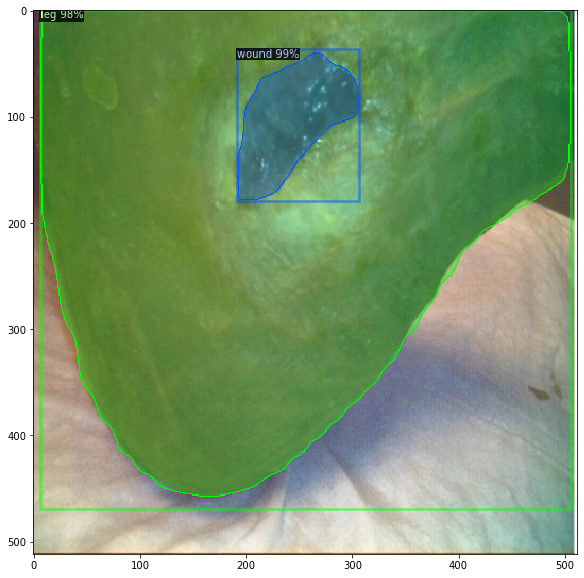

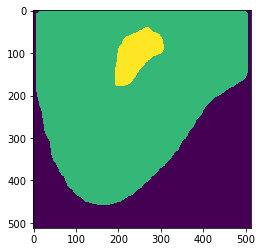

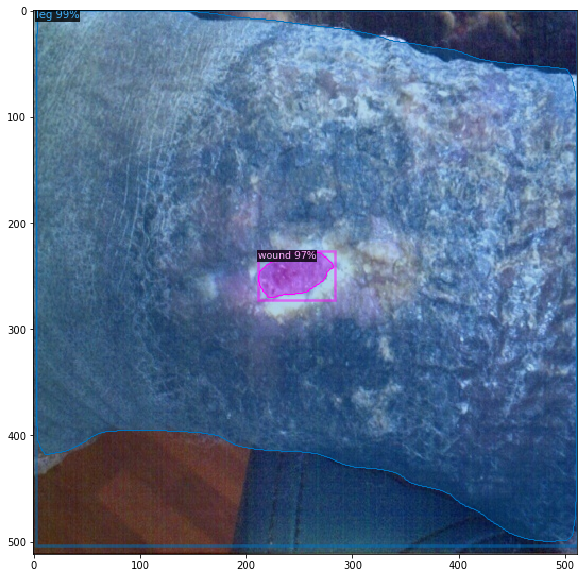

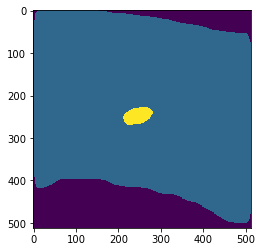

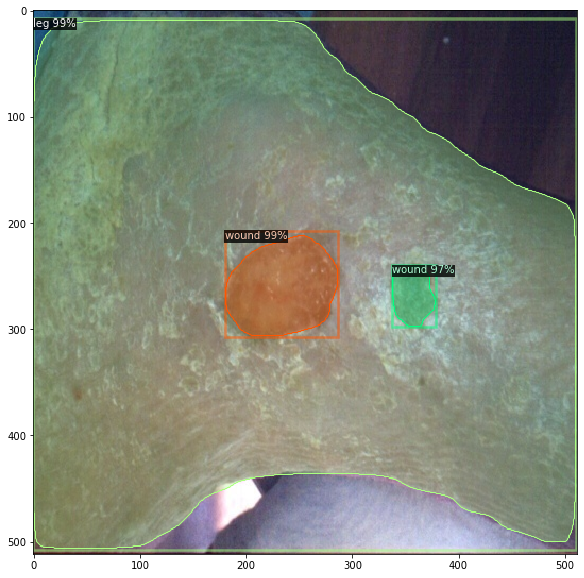

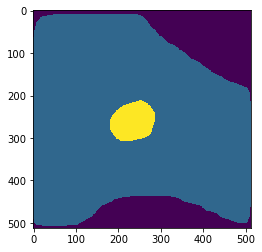

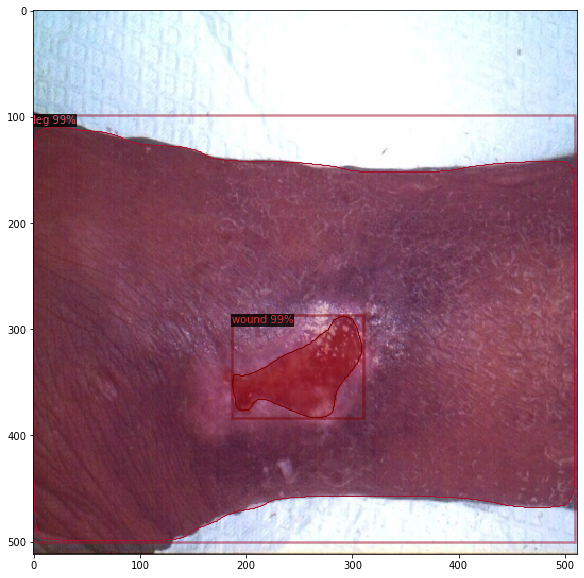

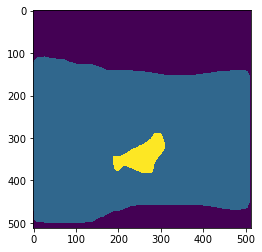

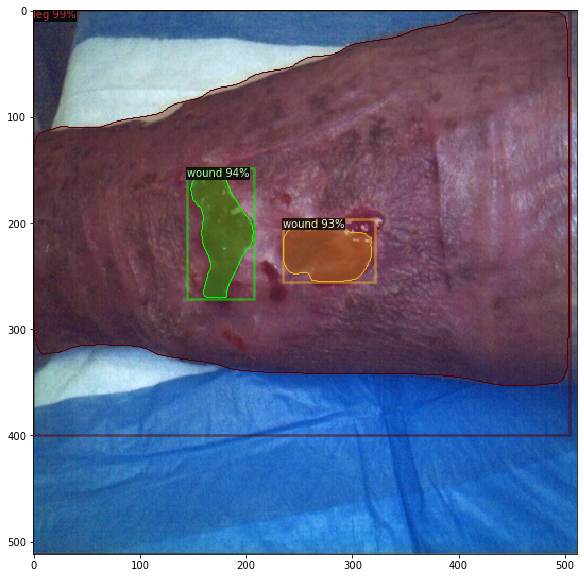

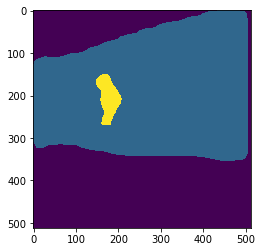

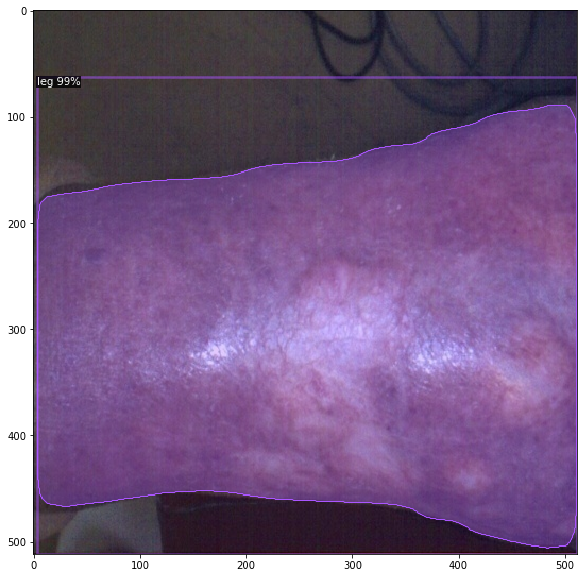

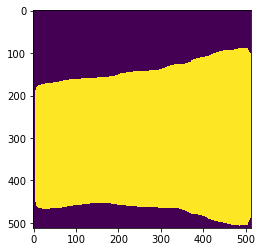

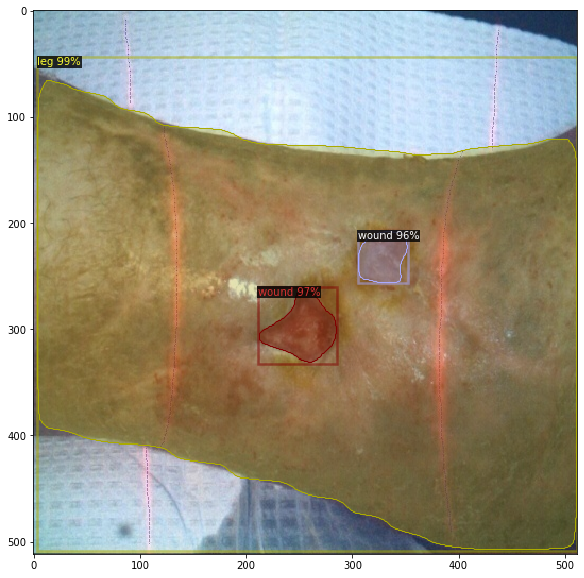

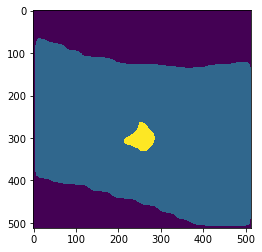

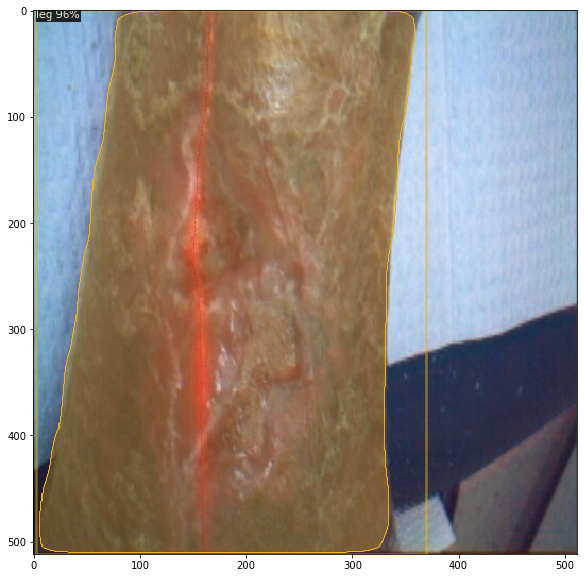

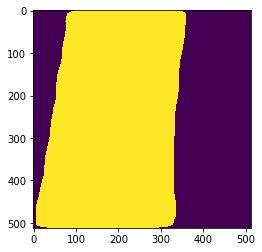

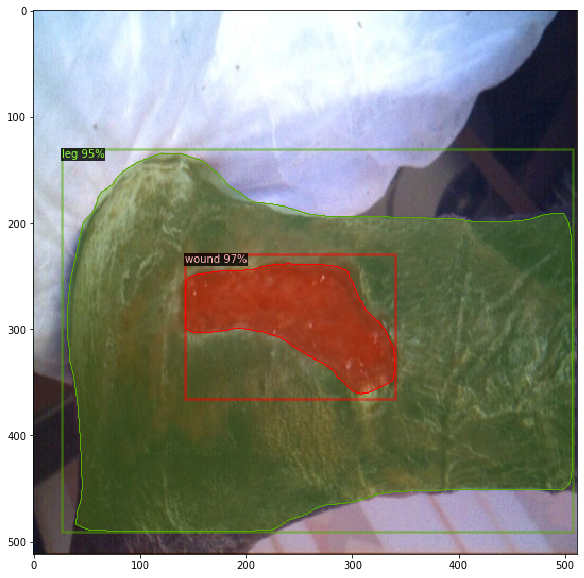

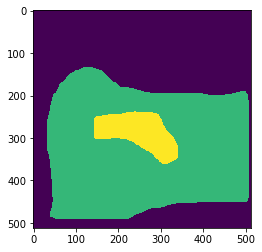

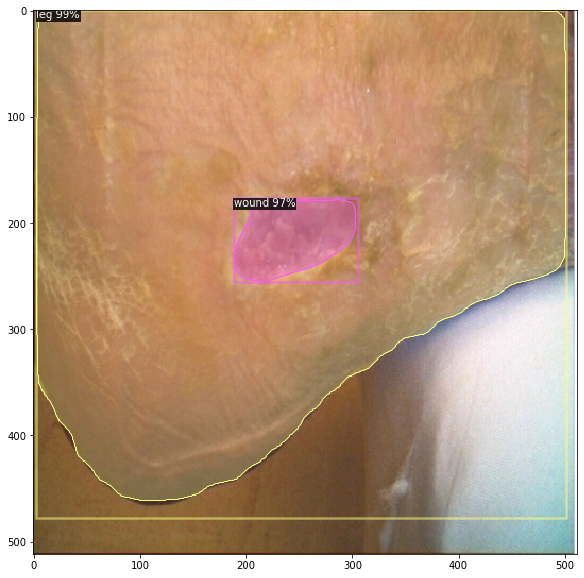

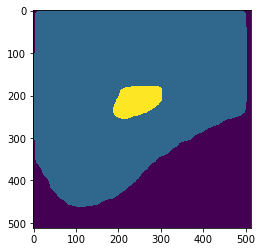

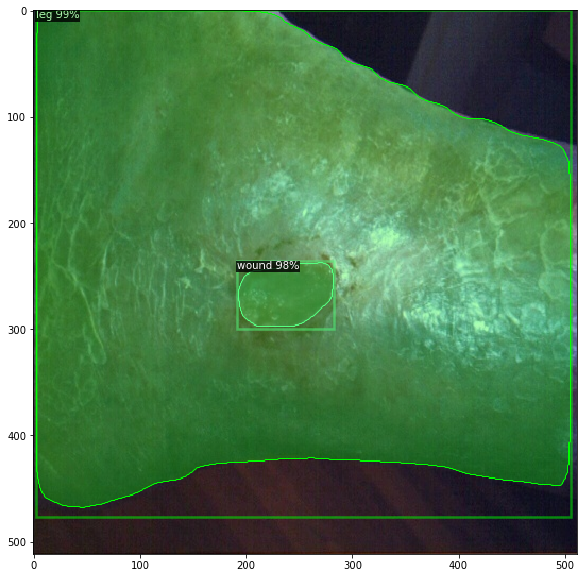

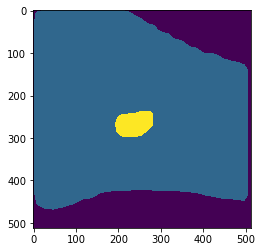

In [9]:
import os
import torch
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.90
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_wound_dict(path_divided["test"])
for d in random.sample(dataset_dicts, 12):   
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wound_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    t_plot_leg = outputs["instances"].to("cpu").pred_masks[0].long()
    if len(outputs["instances"].scores) != 1:
        t_plot_wound = outputs["instances"].to("cpu").pred_masks[1].long()
        plt.imshow(t_plot_leg.numpy()+ t_plot_wound.numpy()*2)
    else:
        plt.imshow(t_plot_leg.numpy())
    #plt.plot(torch.reshape(outputs["instances"].to("cpu").pred_masks[0],(512,512)))
#     plt.figure(figsize = (14, 10))
#     plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show() 

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wound_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "wound_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[07/12 18:47:05 d2.evaluation.coco_evaluation]: 'wound_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/12 18:47:05 d2.data.datasets.coco]: Converting annotations of dataset 'wound_test' to COCO format ...)
[07/12 18:47:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/12 18:47:06 d2.data.datasets.coco]: Conversion finished, #images: 74, #annotations: 154
[07/12 18:47:06 d2.data.datasets.coco]: Caching COCO format annotations at './output/wound_test_coco_format.json' ...
[07/12 18:47:06 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    leg     | 73           |   wound    | 81           |
|            |              |            |              |
|   total    | 154          |            |              |
[07/12 18:47:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations

In [24]:
dataset_dicts

[{'file_name': 'dataset/data_final/test/350/350.jpg',
  'image_id': 'dataset/data_final/test/350/350.jpg',
  'height': 512,
  'width': 512,
  'annotations': [{'bbox': [238.25409836065575,
     227.73770491803276,
     268.58196721311475,
     298.775956284153],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'segmentation': [[243.172131147541,
      232.65573770491804,
      241.12295081967213,
      243.58469945355193,
      244.4016393442623,
      249.59562841530055,
      240.30327868852459,
      253.9672131147541,
      238.25409836065575,
      262.7103825136612,
      239.0737704918033,
      280.1967213114754,
      246.04098360655738,
      292.21857923497265,
      251.77868852459017,
      298.775956284153,
      261.2049180327869,
      298.2295081967213,
      268.58196721311475,
      287.8469945355191,
      263.6639344262295,
      272.5464480874317,
      264.4836065573771,
      258.88524590163934,
      262.4344262295082,
      244.1311475409836,
      257.1065573770491